In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer

import category_encoders as ce

In [29]:
df = pd.read_csv('../data/df_clean_nulls2.csv', index_col=0)
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major,company_size,company_type,last_new_job,training_hours,target,exp_range,city_group
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,NaN,NaN,1,36,1.0,>20,0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,50-99,private_limited,>4,47,0.0,11-15,3
2,11561,city_21,0.624,NaN,0,full_time,Graduate,STEM,NaN,NaN,never,83,0.0,2-5,1
3,33241,city_115,0.789,NaN,0,NaN,Graduate,Business Degree,NaN,private_limited,never,52,1.0,<=1,3
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,50-99,startup_funded,4,8,0.0,>20,3


In [30]:
df.shape

(21269, 15)

# I. Separate Train and Test Sets

In [31]:
train = df.loc[df['target'].notna()]
test = df.loc[df['target'].isna()]

train.shape, test.shape

((19146, 15), (2123, 15))

In [32]:
X_train = train.drop(columns=['target', 'city'])
y_train = train.target

X_test = test.drop(columns=['target', 'city'])
y_test = test.target

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19146, 13), (2123, 13), (19146,), (2123,))

# II. Encoding Categorical Columns

In [33]:
X_train.dtypes[X_train.dtypes=='object']

gender                 object
enrolled_university    object
education_level        object
major                  object
company_size           object
company_type           object
last_new_job           object
exp_range              object
dtype: object

### a) Ordinal Columns

In [34]:
ord_cols = ['education_level', 'company_size', 'last_new_job', 'exp_range']

In [35]:
X_train['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [36]:
ord_map = [
    {'col': 'education_level',
    'mapping': {'Primary School':0, 'High School':1, 'Graduate':2, 'Masters':3, 'Phd':4}},
    {'col': 'company_size',
     'mapping': {'<10': 0, '10-49': 1, '50-99': 2, '100-499':3, '500-999':4, '1000-4999':5, '5000-9999':6, '10000+':7}},
    {'col': 'last_new_job',
     'mapping': {'never': 0, '1': 1, '2': 2, '3':3, '4':4, '>4':5}},
    {'col': 'exp_range', 
     'mapping': {'<=1':0, '2-5':1, '6-10':2, '11-15':3, '16-20':4,'>20':5}}
]

In [37]:
ord_encoder = ce.OrdinalEncoder(
    cols=ord_cols, mapping=ord_map, return_df=True,
    handle_unknown='return_nan', handle_missing='return_nan'
)

ord_encoder.fit(X_train)

X_train = ord_encoder.transform(X_train)
X_test = ord_encoder.transform(X_test)

In [38]:
X_train.shape, X_test.shape

((19146, 13), (2123, 13))

In [39]:
# Original df

df[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
0,Graduate,NaN,1,>20
1,Graduate,50-99,>4,11-15
2,Graduate,NaN,never,2-5
3,Graduate,NaN,never,<=1
4,Masters,50-99,4,>20


In [40]:
# Encoded df

X_train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
0,2.0,NaN,1.0,5.0
1,2.0,2.0,5.0,3.0
2,2.0,NaN,0.0,1.0
3,2.0,NaN,0.0,0.0
4,3.0,2.0,4.0,5.0


In [41]:
X_train[ord_cols].dtypes

education_level    float64
company_size       float64
last_new_job       float64
exp_range          float64
dtype: object

Looks good. After imputing missing values, these columns will be converted to int.

### b) One-Hot Encode Columns

In [42]:
cat_cols = ['gender', 'enrolled_university', 'major', 'company_type']

In [43]:
oh_encoder = ce.OneHotEncoder(cols=cat_cols, return_df=True, use_cat_names=True,
                           handle_unknown='return_nan', handle_missing='return_nan')

oh_encoder.fit(X_train)

X_train = oh_encoder.transform(X_train)
X_test = oh_encoder.transform(X_test)

In [44]:
X_train.shape, X_test.shape

((19146, 31), (2123, 31))

In [45]:
# Create new list of cat_cols

cat_cols2 = []
for i in cat_cols:
    for col_name in X_train.columns:
        if i in col_name:
            cat_cols2.append(col_name)
cat_cols2

['gender_Male',
 'gender_nan',
 'gender_Female',
 'gender_Other',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_nan',
 'enrolled_university_part_time',
 'major_STEM',
 'major_Business Degree',
 'major_nan',
 'major_Arts',
 'major_Humanities',
 'major_No Major',
 'major_Other',
 'company_type_nan',
 'company_type_private_limited',
 'company_type_startup_funded',
 'company_type_startup_earlystage',
 'company_type_Other',
 'company_type_public_sector',
 'company_type_NGO']

In [46]:
# Original df

df[cat_cols].head()

,gender,enrolled_university,major,company_type
0,Male,no_enrollment,STEM,NaN
1,Male,no_enrollment,STEM,private_limited
2,NaN,full_time,STEM,NaN
3,NaN,NaN,Business Degree,private_limited
4,Male,no_enrollment,STEM,startup_funded


In [47]:
# After encoding

X_train[cat_cols2].head()

,gender_Male,gender_nan,gender_Female,gender_Other,enrolled_university_no_enrollment,enrolled_university_full_time,enrolled_university_nan,enrolled_university_part_time,major_STEM,major_Business Degree,...,major_Humanities,major_No Major,major_Other,company_type_nan,company_type_private_limited,company_type_startup_funded,company_type_startup_earlystage,company_type_Other,company_type_public_sector,company_type_NGO
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### c) Ensure all column dtypes are correct

In [48]:
X_train.dtypes

enrollee_id                            int64
city_development_index               float64
gender_Male                          float64
gender_nan                           float64
gender_Female                        float64
gender_Other                         float64
relevent_experience                    int64
enrolled_university_no_enrollment    float64
enrolled_university_full_time        float64
enrolled_university_nan              float64
enrolled_university_part_time        float64
education_level                      float64
major_STEM                           float64
major_Business Degree                float64
major_nan                            float64
major_Arts                           float64
major_Humanities                     float64
major_No Major                       float64
major_Other                          float64
company_size                         float64
company_type_nan                     float64
company_type_private_limited         float64
company_ty

# II. Imputing Missing Values

### a) Ordinal Columns

In [49]:
# Number of NAs in each column

perc_na = round(X_train[ord_cols].isna().sum() * 100 / len(X_train[ord_cols]), 2)

pd.DataFrame({'Total NA':X_train[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,448,2.34
company_size,5926,30.95
last_new_job,411,2.15
exp_range,65,0.34


In [50]:
# Number of NAs in each column

perc_na = round(X_test[ord_cols].isna().sum() * 100 / len(X_test[ord_cols]), 2)

pd.DataFrame({'Total NA':X_test[ord_cols].isna().sum(), '% NA':perc_na})

,Total NA,% NA
education_level,47,2.21
company_size,616,29.02
last_new_job,35,1.65
exp_range,4,0.19


In [51]:
KNN_imputer = KNNImputer()

KNN_imputer.fit(X_train[ord_cols])

X_train[ord_cols] = KNN_imputer.transform(X_train[ord_cols])
X_test[ord_cols] = KNN_imputer.transform(X_test[ord_cols])

In [52]:
X_train[ord_cols].isna().sum()

education_level    0
company_size       0
last_new_job       0
exp_range          0
dtype: int64

In [53]:
# Convert ord cols to int

X_train[ord_cols] = round(X_train[ord_cols], 0)
X_test[ord_cols] = round(X_test[ord_cols], 0)

X_train[ord_cols].head()

,education_level,company_size,last_new_job,exp_range
0,2.0,3.0,1.0,5.0
1,2.0,2.0,5.0,3.0
2,2.0,3.0,0.0,1.0
3,2.0,4.0,0.0,0.0
4,3.0,2.0,4.0,5.0


In [54]:
X_train['education_level'].value_counts(), X_test['education_level'].value_counts()

(2.0    12020
 3.0     4381
 1.0     2023
 4.0      414
 0.0      308
 Name: education_level, dtype: int64,
 2.0    1310
 3.0     501
 1.0     222
 4.0      54
 0.0      36
 Name: education_level, dtype: int64)

In [55]:
X_train['company_size'].value_counts()

3.0    4765
2.0    4323
4.0    2484
7.0    2019
5.0    1874
1.0    1588
0.0    1471
6.0     622
Name: company_size, dtype: int64

In [56]:
X_train['last_new_job'].value_counts()

1.0    8196
5.0    3292
2.0    3046
0.0    2504
3.0    1068
4.0    1040
Name: last_new_job, dtype: int64

In [57]:
X_train['exp_range'].value_counts()

1.0    5317
2.0    5035
5.0    3283
3.0    2852
4.0    1589
0.0    1070
Name: exp_range, dtype: int64

The distributions don't seem to have changed.

### b) One-Hot Columns

In [58]:
# Number of NAs in each column

perc_na = round(X_train[cat_cols2].isna().sum() * 100 / len(X_train[cat_cols2]), 2)

pd.DataFrame({'Total NA':X_train[cat_cols2].isna().sum(), '% NA':perc_na})

,Total NA,% NA
gender_Male,4496,23.48
gender_nan,4496,23.48
gender_Female,4496,23.48
gender_Other,4496,23.48
enrolled_university_no_enrollment,374,1.95
enrolled_university_full_time,374,1.95
enrolled_university_nan,374,1.95
enrolled_university_part_time,374,1.95
major_STEM,2801,14.63
major_Business Degree,2801,14.63


In [59]:
gender_cols = ['gender_Male', 'gender_Female', 'gender_Other']
enrolled_cols = ['enrolled_university_no_enrollment', 'enrolled_university_full_time', 'enrolled_university_part_time']
major_cols = ['major_STEM', 'major_Business Degree', 'major_Arts', 'major_Humanities', 'major_No Major', 'major_Other']
company = ['company_type_Pvt Ltd', 'company_type_Funded Startup', 'company_type_Early Stage Startup', 'company_type_Other',
           'company_type_Public Sector', 'company_type_NGO']

In [60]:
nan_cols = ['gender_nan', 'enrolled_university_nan', 'major_nan', 'company_type_nan']

# Remove NaN columns from catcols2
[cat_cols2.remove(i) for i in nan_cols]

# Remove NaN cols from df
X_train.drop(columns=nan_cols, inplace=True)
X_test.drop(columns=nan_cols, inplace=True)

cat_cols2

['gender_Male',
 'gender_Female',
 'gender_Other',
 'enrolled_university_no_enrollment',
 'enrolled_university_full_time',
 'enrolled_university_part_time',
 'major_STEM',
 'major_Business Degree',
 'major_Arts',
 'major_Humanities',
 'major_No Major',
 'major_Other',
 'company_type_private_limited',
 'company_type_startup_funded',
 'company_type_startup_earlystage',
 'company_type_Other',
 'company_type_public_sector',
 'company_type_NGO']

In [61]:
KNN_imputer = KNNImputer(n_neighbors=1)

KNN_imputer.fit(X_train[cat_cols2])

X_train[cat_cols2] = KNN_imputer.transform(X_train[cat_cols2])
X_test[cat_cols2] = KNN_imputer.transform(X_test[cat_cols2])

In [62]:
X_train[cat_cols2].isna().sum()

gender_Male                          0
gender_Female                        0
gender_Other                         0
enrolled_university_no_enrollment    0
enrolled_university_full_time        0
enrolled_university_part_time        0
major_STEM                           0
major_Business Degree                0
major_Arts                           0
major_Humanities                     0
major_No Major                       0
major_Other                          0
company_type_private_limited         0
company_type_startup_funded          0
company_type_startup_earlystage      0
company_type_Other                   0
company_type_public_sector           0
company_type_NGO                     0
dtype: int64

In [63]:
# Convert ord cols to int
X_train[cat_cols2] = round(X_train[cat_cols2], 0)
X_test[cat_cols2] = round(X_test[cat_cols2], 0)

X_train[cat_cols2].head()

,gender_Male,gender_Female,gender_Other,enrolled_university_no_enrollment,enrolled_university_full_time,enrolled_university_part_time,major_STEM,major_Business Degree,major_Arts,major_Humanities,major_No Major,major_Other,company_type_private_limited,company_type_startup_funded,company_type_startup_earlystage,company_type_Other,company_type_public_sector,company_type_NGO
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [64]:
X_train[gender_cols].value_counts()

gender_Male  gender_Female  gender_Other
1.0          0.0            0.0             16525
0.0          1.0            0.0              2416
             0.0            1.0               205
dtype: int64

In [65]:
df['major'].value_counts()

STEM               16113
Humanities           749
Other                421
Business Degree      364
Arts                 270
No Major             245
Name: major, dtype: int64

In [66]:
X_train[major_cols].value_counts()

major_STEM  major_Business Degree  major_Arts  major_Humanities  major_No Major  major_Other
1.0         0.0                    0.0         0.0               0.0             0.0            17179
0.0         0.0                    0.0         1.0               0.0             0.0              669
            1.0                    0.0         0.0               0.0             0.0              432
            0.0                    0.0         0.0               0.0             1.0              381
                                   1.0         0.0               0.0             0.0              262
                                   0.0         0.0               1.0             0.0              223
dtype: int64

This distribution doesn't seem to follow the original exactly.

In [67]:
X_train.isna().sum(), X_test.isna().sum()

(enrollee_id                          0
 city_development_index               0
 gender_Male                          0
 gender_Female                        0
 gender_Other                         0
 relevent_experience                  0
 enrolled_university_no_enrollment    0
 enrolled_university_full_time        0
 enrolled_university_part_time        0
 education_level                      0
 major_STEM                           0
 major_Business Degree                0
 major_Arts                           0
 major_Humanities                     0
 major_No Major                       0
 major_Other                          0
 company_size                         0
 company_type_private_limited         0
 company_type_startup_funded          0
 company_type_startup_earlystage      0
 company_type_Other                   0
 company_type_public_sector           0
 company_type_NGO                     0
 last_new_job                         0
 training_hours                       0


# III. Scale Data

In [68]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

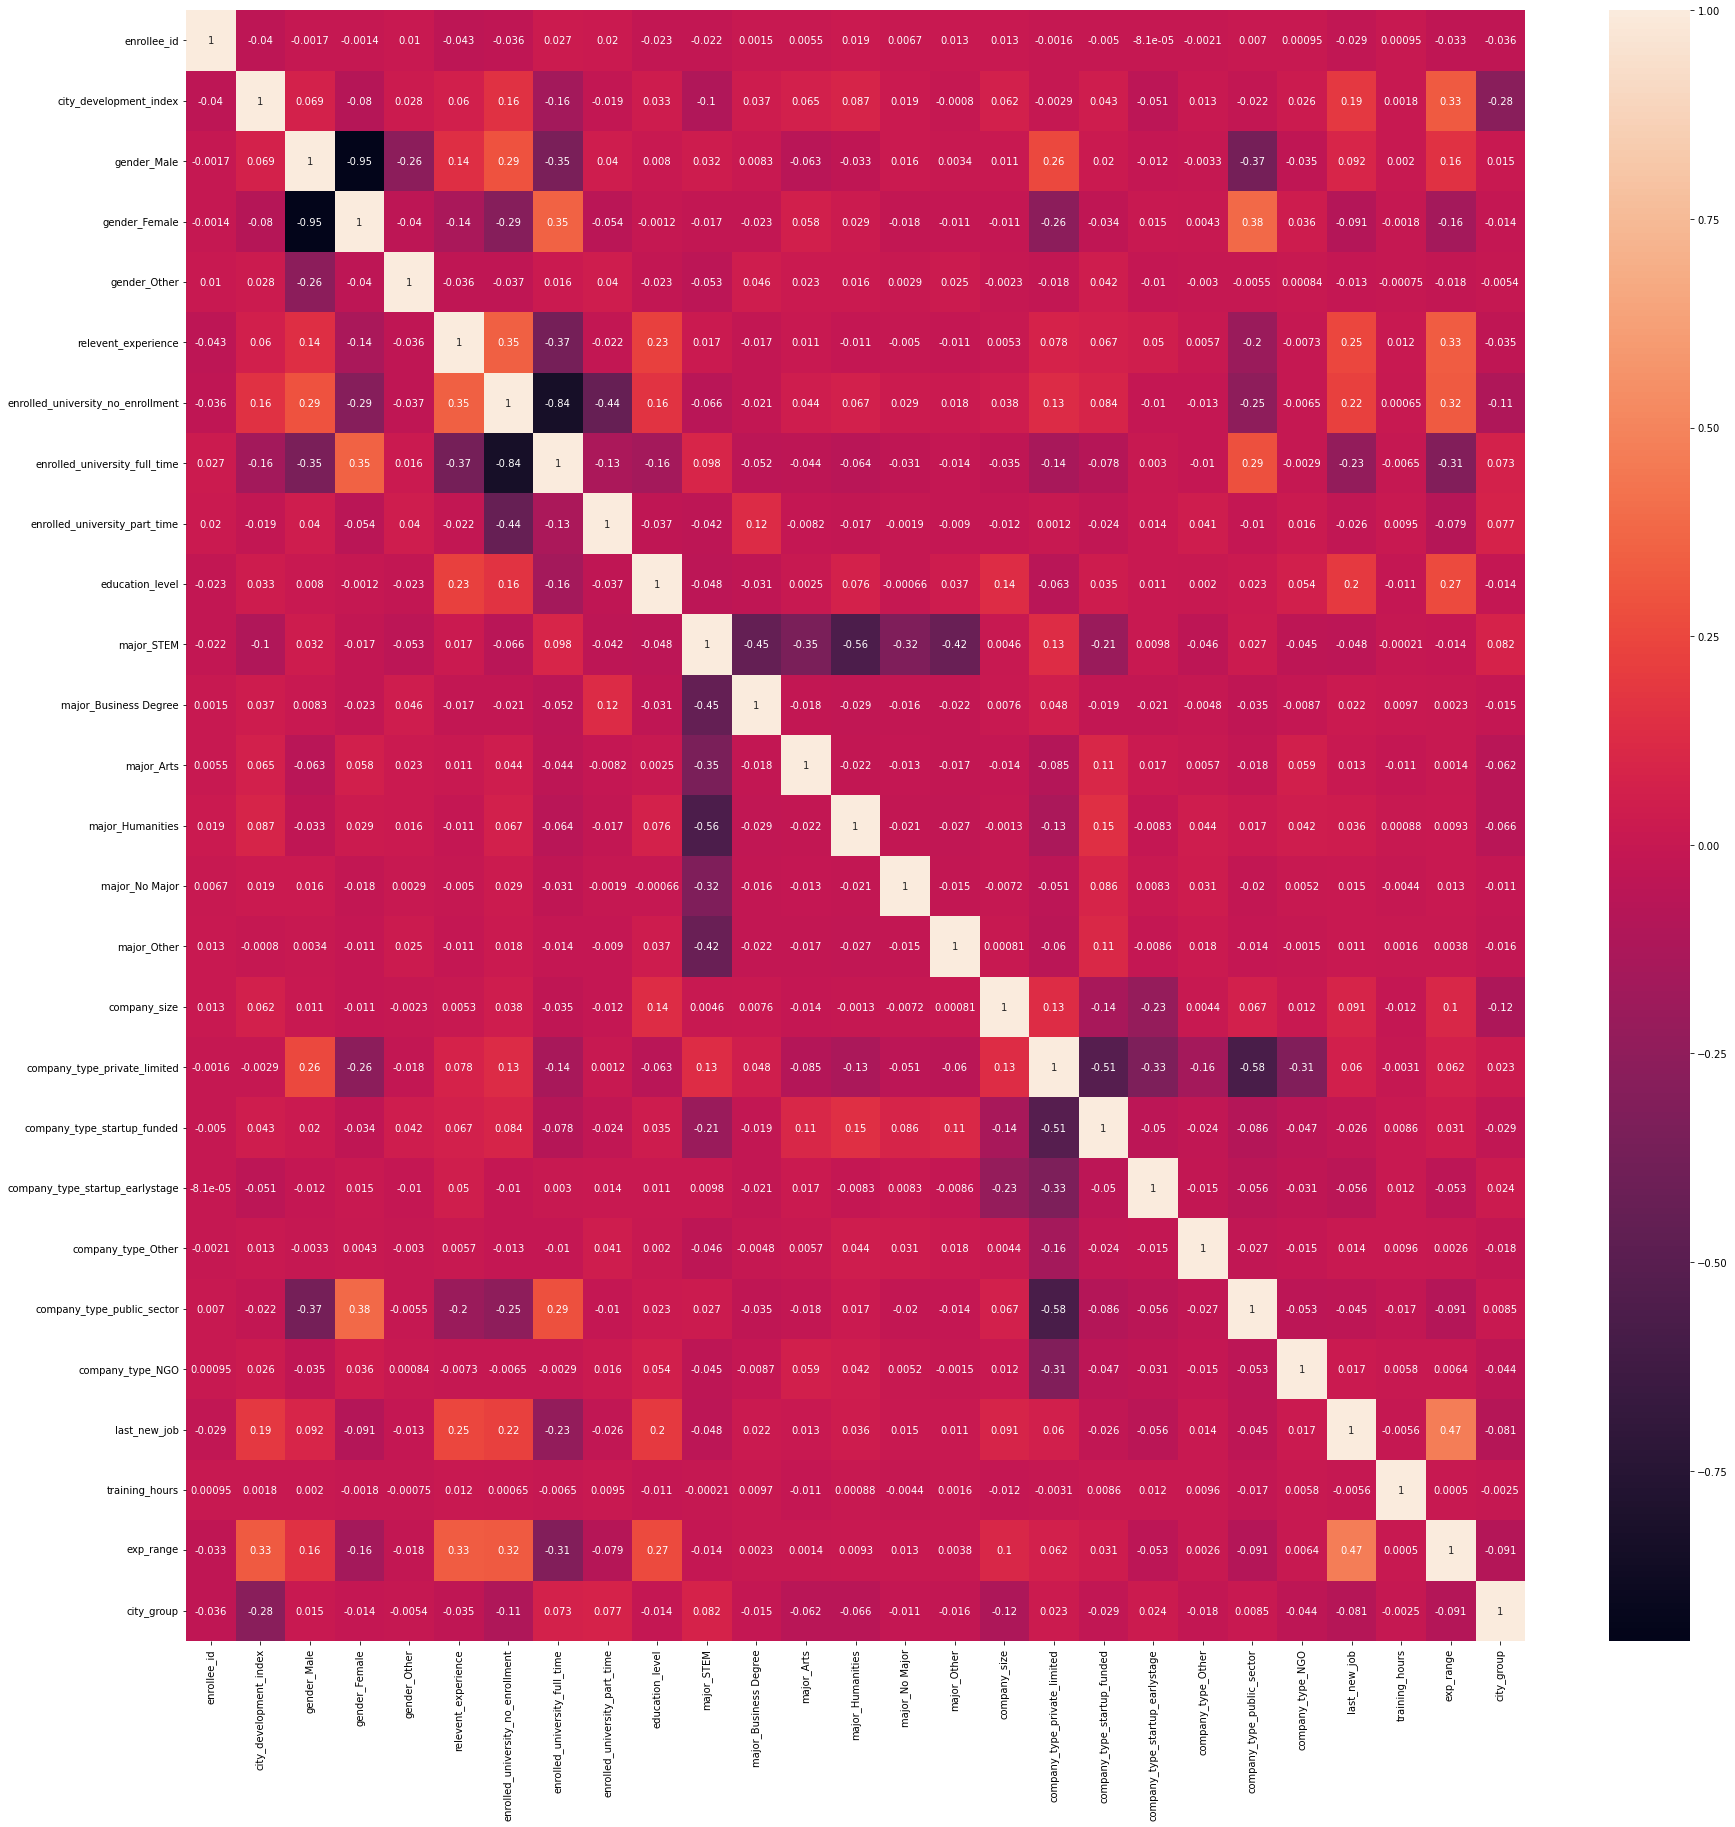

In [71]:
# Check for multicollinearity again, now that all columns are numerical and imputed

plt.figure(figsize=(30,30))
sns.heatmap(X_train.corr(), annot=True);

# IV. Save Train/Test Data?